This file is part of GaPSE
Copyright (C) 2022 Matteo Foglieni

GaPSE is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

GaPSE is distributed in the hope that it will be useful, but
WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU
General Public License for more details.

You should have received a copy of the GNU General Public License
along with GaPSE. If not, see <http://www.gnu.org/licenses/>.
```


```

In [1]:
maximum_comoving_distance = 1.389556413208e+04;

In [2]:
max_co_dist_for_survey = 1.389556413208e+04/3

4631.854710693334

In [3]:
corr_max_redshift_for_survey = 1.663683173266e+00

1.663683173266

$$
    \int_{-1}^{1} dy (2y^2+1) = \frac{2}{3}y^3 +y\bigg|^{1}_{-1} = 
        (\frac{2}{3} + 1) - (-\frac{2}{3} - 1)= \frac{4}{3} + 2 = \frac{10}{3}
$$

# Effective 𝑓_NL

This ipynb provides the code necessary to compute the effective factor of Non-Linear effects $\mathit{f}_{\rm NL}$.

All the output files will be placed in the following directory:

In [4]:
#DIR = "/Users/matteofoglieni/Dropbox/GR_effects/Matteo_Output/fNL_effective_z115/";
DIR = "Effective_fNL_z115_files/";

ps_kwargs(twofast::Bool) = twofast ?
    Dict(:twofast=>true, :epl => true, :pr => false, 
          :N_left => 12, :N_right => 12,
          :p0_left => [-2.0, 1.0], :p0_right => [-2.0, 1.0],
          :int_s_min => 1e0, :int_s_max => 1200.0) :
    Dict(:twofast=>false, :pr=>true, :ν => 1.5, :n_extrap_low => 0,
     :n_extrap_high => 0, :n_pad => 500, :cut_first_n=>6);
tf = false;

## Basic Framework

In [5]:
PATH_TO_GAPSE = "../";

In [6]:
include(PATH_TO_GAPSE * "src/GaPSE.jl");

In [7]:
using DelimitedFiles, Plots, Dierckx, SpecialFunctions
using Printf, LaTeXStrings, Turing, StatsPlots, GridInterpolations

In [8]:
#z_min, z_max, θ_max = 0.05, 0.20, π / 2.0
z_min, z_max, θ_max = 1.0, 1.5, π / 2.0

WFI_opts = Dict(
    :ss_start => 0.0, :ss_stop => 0.0, 
    :ss_step => 50, :llim => 0.0, :rlim => Inf, 
    :rtol => 5e-2, :atol => 0.0, :N => 1000, #:pr => true,
)

FILE_F_MAP = PATH_TO_GAPSE * "data/F_REFERENCE_pi2.txt"
FILE_PS = PATH_TO_GAPSE * "test/datatest/file_pk.txt"
FILE_BACKGROUND = PATH_TO_GAPSE * "test/datatest/WideA_ZA_background.dat"

params = GaPSE.CosmoParams(z_min, z_max, θ_max;
    Ω_b = 0.0489, Ω_cdm = 0.251020, h_0 = 0.70, s_lim=1e-2,
    s_b = 0.0, 𝑓_evo = 0.0, b = 1.0,
    IPS_opts = Dict(
        :fit_left_min => 1e-6, :fit_left_max => 3e-6,
        :fit_right_min => 1e1, :fit_right_max => 2e1),
    IPSTools_opts = Dict(
        :N => 1024, :fit_min => 0.05, :fit_max => 0.5, 
        :con => true, :k_min => 1e-8, :k_max => 10.0),
    WFI_opts = WFI_opts,
);

In [9]:
#=
new_calc_μs = union([μ for μ in -1.0:0.01:(-0.9)], 
        [μ for μ in -0.9:0.05:0.9], 
        [μ for μ in 0.9:0.01:1.0]);
FILE_IF_MAP = PATH_TO_GAPSE*"data/IntF_pi2_z115.txt"

GaPSE.print_map_IntegratedF(
    FILE_F_MAP, FILE_IF_MAP, 
    z_min, z_max, new_calc_μs, FILE_BACKGROUND;
    trap = true, WFI_opts...
)
=#

In [10]:
FILE_IF_MAP = PATH_TO_GAPSE*"data/IntF_pi2_z115.txt"
cosmo = GaPSE.Cosmology(params, FILE_BACKGROUND, FILE_PS, FILE_F_MAP, FILE_IF_MAP);

GaPSE.parameters_used(stdout, cosmo)

###############
#    GaPSE    #
############### 
#
# The Cosmology considered had the following paremeters:
# 
# - Matter Power Spectrum input file: "../test/datatest/file_pk.txt"
# - Background data input file: "../test/datatest/WideA_ZA_background.dat"
# - F window function input file: "../data/F_REFERENCE_pi2.txt"
# - Integrated F window function input file: "../data/IntF_pi2_z115.txt"
#
# - Basic CosmoParams considered: 
#	 z_min = 1.0 	 z_max = 1.5
#	 θ_max = 1.5707963267948966 [rad] 	 h_0 = 0.7
#	 Ω_b = 0.0489 	 Ω_cdm = 0.25102 	 Ω_M0 = 0.29992
#	 b = 1.0 	 f_evo = 0.0 	 s_b = 0.0
#
# - CosmoParams about the Input Power Spectrum: 
#	 fit_left_min = 1.0e-6 	 fit_right_min = 10.0 	 
#	 fit_left_max = 3.0e-6 	 fit_right_max = 20.0 	 
#
# - CosmoParams about the Input Power Spectrum Tools: 
#	 k_max = 10.0 	 fit_max = 0.5 	 N = 1024 	 
#	 con = true 	 k_min = 1.0e-8 	 fit_min = 0.05 	 
#
# - CosmoParams about the Integrated Window Function F: 
#	 ss_step = 50 	 N = 1000 	 rtol = 0.05

## Check window function F an integrated IF

In [11]:
#=
my_matrix = readdlm(FILE_F_MAP, comments=true)
my_xs = convert(Vector{Float64}, my_matrix[:,1])
my_μs = convert(Vector{Float64}, my_matrix[:,2])
my_Fs = convert(Vector{Float64}, my_matrix[:,3]);
my_F_grid = GridInterpolations.RectangleGrid( unique(my_μs), unique(my_xs))
my_spline_F(x, μ) = GridInterpolations.interpolate(my_F_grid, my_Fs, [μ, x]);
=#

In [12]:
#=
my_Imatrix = readdlm(FILE_IF_MAP, comments=true)
my_Iss = convert(Vector{Float64}, my_Imatrix[:,1])
my_Iμs = convert(Vector{Float64}, my_Imatrix[:,2])
my_IFs = convert(Vector{Float64}, my_Imatrix[:,3]);
my_IF_grid = GridInterpolations.RectangleGrid( unique(my_Iμs), unique(my_Iss))
my_spline_IF(s, μ) = GridInterpolations.interpolate(my_IF_grid, my_IFs, [μ, s]);
=#

In [13]:
#=
p1 = plot(my_xs, my_μs, my_Fs; xl="s", yl="μ", zl="int", 
    st = :surface, c=cgrad([:yellow, :red]), size=(600, 300), 
    title="my F", legend = false)
p2 = plot(my_Iss, my_Iμs, my_IFs; xl="s", yl="μ", zl="intF", 
    st = :surface, c=cgrad([:yellow, :red]), size=(600, 300), 
    title="my IntF", legend = false)
plot(p1, p2, size=(1200, 400))
=#

In [14]:
#=
pyplot()

title = plot(title = "Slices of F for different x values", grid=false, 
    showaxis = false, bottom_margin = -50Plots.px, ticks=false)

θ_max =  π/2.0;
xs = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0];
μs = range(-1.0, 1.0, length=100);

LIST_P = [plot() for i in 1:length(xs)]
for (i,x) in enumerate(xs)
    tit = "\n\n x = $x"
    xs_1 = μs
    ys_1 = [my_spline_F(x, μ) for μ in xs_1]

    LIST_P[i] = plot(xs_1, ys_1, 
        #xaxis=:log, yaxis=:log, 
        lc=:red, title=tit, legend=false,
        ylabel=L"F(x,\mu)", ls=:solid, 
        #xticks=10.0 .^ range(-3,0, step=1),
    )
end

l = @layout [ A{0.003h} ; a b c d ; e f g h ; i l j _]
ALL_PLOTS = plot(title, LIST_P..., layout=l,
    left_margins = 15Plots.px, right_margins = 15Plots.px, size=(1000,700))
=#

In [15]:
#=
pyplot()

title = plot(title = "Slices of IF for different s values", grid=false, 
    showaxis = false, bottom_margin = -50Plots.px, ticks=false)

θ_max =  π/2.0;
ss = vcat([10.0], [i*max(my_Iss...)/6 for i in 1:5]);
μs = range(-1.0, 1.0, length=100);

LIST_P = [plot() for i in 1:length(ss)]
for (i,s) in enumerate(ss)
    tit = "\n\n s = $s [Mpc/h_0]"
    xs_1 = μs
    ys_1 = [my_spline_IF(s, μ) for μ in xs_1]

    LIST_P[i] = plot(xs_1, ys_1, 
        #xaxis=:log, yaxis=:log, 
        lc=:red, title=tit, legend=false,
        ylabel=L"IF(s,\mu)", ls=:solid, 
        #xticks=10.0 .^ range(-3,0, step=1),
    )
end

l = @layout [ A{0.003h} ; a b c ; d e f ]
ALL_PLOTS = plot(title, LIST_P..., layout=l,
    left_margins = 15Plots.px, right_margins = 15Plots.px, size=(1000,500))
=#

## Computation of the Matter TPCF and PS from the CLASS one

In [16]:
in_file_ps = FILE_PS;
out_xi_matter_L0 = DIR*"xi_matter_L0.txt";
out_ps_matter_L0 = DIR*"ps_matter_L0.txt";

In [17]:
GaPSE.print_ξ_from_PS(in_file_ps, out_xi_matter_L0; 
    int_k_min = 1/(2*cosmo.s_max), int_k_max = 1e1,
     L = 0, N = 1024, pr = true,
     s0 = nothing, right = nothing);

GaPSE.print_PS_multipole(out_xi_matter_L0, out_ps_matter_L0;
     L = 0, ps_kwargs(tf)...);


I'm computing the TPCF from the file "../test/datatest/file_pk.txt" 

time needed for this TPCF computation [in s] = 0.16672897338867188


I'm computing the PS_multipole from the file "Effective_fNL_z115_files/xi_matter_L0.txt" 

time needed for this Power Spectrum computation [in s] = 0.19386792182922363



In [18]:
ss_matter_L0, xis_matter_L0 = GaPSE.readxy(out_xi_matter_L0);
ks_matter_L0, pks_matter_L0 = GaPSE.readxy(out_ps_matter_L0);

## Matter TPCF and PS L=0,2,4 in PP Approximation

In [19]:
#=
out_xi_ppmatter_L0_withF = DIR*"xi_ppmatter_L0_withF.txt";
out_ps_ppmatter_L0_withF = DIR*"ps_ppmatter_L0_withF.txt";

GaPSE.print_map_ξ_PPMatter_multipole(cosmo, 
    out_xi_ppmatter_L0_withF, 10 .^ range(0,log10(2*cosmo.s_max),length=1000);
    L = 0, use_windows = true, pr = true, enhancer = 1e6,
    μ_atol = 0.0, μ_rtol = 1e-2);
GaPSE.print_PS_multipole(out_xi_ppmatter_L0_withF, out_ps_ppmatter_L0_withF;
     L = 0, ps_kwargs(tf)...);
ks_ppm_L0_withF, pks_ppm_L0_withF = GaPSE.readxy(out_ps_ppmatter_L0_withF);
=#

In [86]:
out_xi_ppmatter_L0_noF = DIR*"xi_ppmatter_L0_noF.txt";
out_xi_ppmatter_L2_noF = DIR*"xi_ppmatter_L2_noF.txt";
out_xi_ppmatter_L4_noF = DIR*"xi_ppmatter_L4_noF.txt";
out_xi_ppmatter_L0_withF = DIR*"xi_ppmatter_L0_withF.txt";
out_xi_ppmatter_L2_withF = DIR*"xi_ppmatter_L2_withF.txt";
out_xi_ppmatter_L4_withF = DIR*"xi_ppmatter_L4_withF.txt";

out_ps_ppmatter_L0_noF = DIR*"ps_ppmatter_L0_noF.txt";
out_ps_ppmatter_L2_noF = DIR*"ps_ppmatter_L2_noF.txt";
out_ps_ppmatter_L4_noF = DIR*"ps_ppmatter_L4_noF.txt";
out_ps_ppmatter_L0_withF = DIR*"ps_ppmatter_L0_withF.txt";
out_ps_ppmatter_L2_withF = DIR*"ps_ppmatter_L2_withF.txt";
out_ps_ppmatter_L4_withF = DIR*"ps_ppmatter_L4_withF.txt";

In [99]:
GaPSE.print_map_ξ_PPMatter_multipole(cosmo, 
    out_xi_ppmatter_L0_noF, 10 .^ range(0,log10(2*cosmo.s_max),length=1000);
    L = 0, use_windows = false, pr = true, enhancer = 1e6,
    μ_atol = 0.0, μ_rtol = 1e-2);
GaPSE.print_map_ξ_PPMatter_multipole(cosmo, 
    out_xi_ppmatter_L2_noF, 10 .^ range(0,log10(2*cosmo.s_max),length=1000);
    L = 2, use_windows = false, pr = true, enhancer = 1e6,
    μ_atol = 0.0, μ_rtol = 1e-2);
GaPSE.print_map_ξ_PPMatter_multipole(cosmo, 
    out_xi_ppmatter_L4_noF, 10 .^ range(0,log10(2*cosmo.s_max),length=1000);
    L = 4, use_windows = false, pr = true, enhancer = 1e6,
    μ_atol = 0.0, μ_rtol = 1e-2);

GaPSE.print_PS_multipole(out_xi_ppmatter_L0_noF, out_ps_ppmatter_L0_noF;
     L = 0,  ps_kwargs(tf)...);
GaPSE.print_PS_multipole(out_xi_ppmatter_L2_noF, out_ps_ppmatter_L2_noF;
     L = 2,  ps_kwargs(tf)...);
GaPSE.print_PS_multipole(out_xi_ppmatter_L4_noF, out_ps_ppmatter_L4_noF;
     L = 4,  ps_kwargs(tf)...);

PP Matter, L=0: 100%|███████████████████████████████████| Time: 0:00:00



time needed for map_ξ_PPMatter_multipole [in s] = 0.19111 


PP Matter, L=2: 100%|███████████████████████████████████| Time: 0:00:00



time needed for map_ξ_PPMatter_multipole [in s] = 0.17259 


PP Matter, L=4: 100%|███████████████████████████████████| Time: 0:00:00



time needed for map_ξ_PPMatter_multipole [in s] = 0.17206 

I'm computing the PS_multipole from the file "Effective_fNL_z115_files/xi_ppmatter_L0_noF.txt" 

time needed for this Power Spectrum computation [in s] = 0.004895210266113281


I'm computing the PS_multipole from the file "Effective_fNL_z115_files/xi_ppmatter_L2_noF.txt" 

time needed for this Power Spectrum computation [in s] = 0.0025429725646972656


I'm computing the PS_multipole from the file "Effective_fNL_z115_files/xi_ppmatter_L4_noF.txt" 

time needed for this Power Spectrum computation [in s] = 0.0032701492309570312



In [100]:
GaPSE.print_map_ξ_PPMatter_multipole(cosmo, 
    out_xi_ppmatter_L0_withF, 10 .^ range(0,log10(2*cosmo.s_max),length=1000);
    L = 0, use_windows = true, pr = true, enhancer = 1e6,
    μ_atol = 0.0, μ_rtol = 1e-2);
GaPSE.print_map_ξ_PPMatter_multipole(cosmo, 
    out_xi_ppmatter_L2_withF, 10 .^ range(0,log10(2*cosmo.s_max),length=1000);
    L = 2, use_windows = true, pr = true, enhancer = 1e6,
    μ_atol = 0.0, μ_rtol = 1e-2);
GaPSE.print_map_ξ_PPMatter_multipole(cosmo, 
    out_xi_ppmatter_L4_withF, 10 .^ range(0,log10(2*cosmo.s_max),length=1000);
    L = 4, use_windows = true, pr = true, enhancer = 1e6,
    μ_atol = 0.0, μ_rtol = 1e-2);

GaPSE.print_PS_multipole(out_xi_ppmatter_L2_withF, out_ps_ppmatter_L2_withF;
     L = 2, ps_kwargs(tf)...);
GaPSE.print_PS_multipole(out_xi_ppmatter_L4_withF, out_ps_ppmatter_L4_withF;
     L = 4, ps_kwargs(tf)...);

PP Matter, L=0: 100%|███████████████████████████████████| Time: 0:00:08



time needed for map_ξ_PPMatter_multipole [in s] = 8.38628 


PP Matter, L=2: 100%|███████████████████████████████████| Time: 0:00:14



time needed for map_ξ_PPMatter_multipole [in s] = 14.30730 


PP Matter, L=4: 100%|███████████████████████████████████| Time: 0:00:27



time needed for map_ξ_PPMatter_multipole [in s] = 27.83961 

I'm computing the PS_multipole from the file "Effective_fNL_z115_files/xi_ppmatter_L2_withF.txt" 

time needed for this Power Spectrum computation [in s] = 0.002424955368041992


I'm computing the PS_multipole from the file "Effective_fNL_z115_files/xi_ppmatter_L4_withF.txt" 

time needed for this Power Spectrum computation [in s] = 0.0031349658966064453



In [101]:
ss_ppm_L0_noF, xis_ppm_L0_noF = GaPSE.readxy(out_xi_ppmatter_L0_noF);
ss_ppm_L2_noF, xis_ppm_L2_noF = GaPSE.readxy(out_xi_ppmatter_L2_noF);
ss_ppm_L4_noF, xis_ppm_L4_noF = GaPSE.readxy(out_xi_ppmatter_L4_noF);
ss_ppm_L0_withF, xis_ppm_L0_withF = GaPSE.readxy(out_xi_ppmatter_L0_withF);
ss_ppm_L2_withF, xis_ppm_L2_withF = GaPSE.readxy(out_xi_ppmatter_L2_withF);
ss_ppm_L4_withF, xis_ppm_L4_withF = GaPSE.readxy(out_xi_ppmatter_L4_withF);

ks_ppm_L0_noF, pks_ppm_L0_noF = GaPSE.readxy(out_ps_ppmatter_L0_noF);
ks_ppm_L2_noF, pks_ppm_L2_noF = GaPSE.readxy(out_ps_ppmatter_L2_noF);
ks_ppm_L4_noF, pks_ppm_L4_noF = GaPSE.readxy(out_ps_ppmatter_L4_noF);
ks_ppm_L0_withF, pks_ppm_L0_withF = GaPSE.readxy(out_ps_ppmatter_L0_withF);
ks_ppm_L2_withF, pks_ppm_L2_withF = GaPSE.readxy(out_ps_ppmatter_L2_withF);
ks_ppm_L4_withF, pks_ppm_L4_withF = GaPSE.readxy(out_ps_ppmatter_L4_withF);

In [90]:
#=
spline_xi_ppm_L0_noF = Spline1D(ss_ppm_L0_noF, xis_ppm_L0_noF);
spline_xi_ppm_L2_noF = Spline1D(ss_ppm_L2_noF, xis_ppm_L2_noF);
spline_xi_ppm_L4_noF = Spline1D(ss_ppm_L4_noF, xis_ppm_L4_noF);

ss_ppm_tot_noF = ss_ppm_L0_noF;
xis_ppm_tot_noF = [spline_xi_ppm_L0_noF(s) + 
    spline_xi_ppm_L2_noF(s) + spline_xi_ppm_L4_noF(s) for s in ss_ppm_tot_noF];

spline_xi_ppm_L0_withF = Spline1D(ss_ppm_L0_withF, xis_ppm_L0_withF);
spline_xi_ppm_L2_withF = Spline1D(ss_ppm_L2_withF, xis_ppm_L2_withF);
spline_xi_ppm_L4_withF = Spline1D(ss_ppm_L4_withF, xis_ppm_L4_withF);

ss_ppm_tot_withF = ss_ppm_L0_withF;
xis_ppm_tot_withF = [spline_xi_ppm_L0_withF(s) + 
    spline_xi_ppm_L2_withF(s) + spline_xi_ppm_L4_withF(s) for s in ss_ppm_tot_withF];
=#

## Check Matter TPCF L=0,2,4 in PP approx

In [25]:
c_ss_ppm =  10 .^ range(0,log10(2*cosmo.s_max),length=1000)

c_xi_ppm_L0 = [GaPSE.ξ_PP_Matter_L0(s, cosmo) for s in c_ss_ppm];
c_xi_ppm_L2 = [GaPSE.ξ_PP_Matter_L2(s, cosmo) for s in c_ss_ppm];
c_xi_ppm_L4 = [GaPSE.ξ_PP_Matter_L4(s, cosmo) for s in c_ss_ppm];

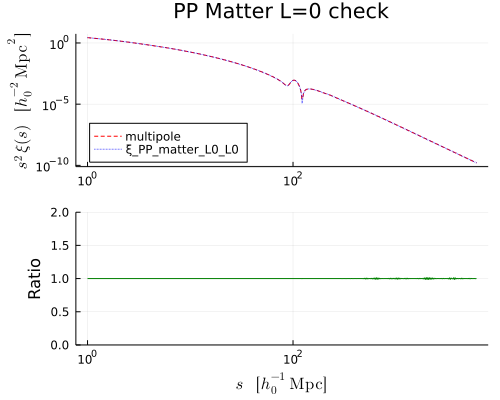

In [26]:
xs_1 = ss_ppm_L0_noF
ys_1 = xis_ppm_L0_noF 
spline = Spline1D(xs_1, ys_1)

xs_2 = c_ss_ppm
ys_2 = c_xi_ppm_L0

p1 = plot([xs_1, xs_2], [abs.(ys_1), abs.(ys_2)],
    xaxis=:log, yaxis=:log, legend=:bottomleft,
    lc=[:red :blue], 
    title = "PP Matter L=0 check",
    label=["multipole" "ξ_PP_matter_L0_L0"], ls=[:dash :dot], 
    ylabel = L"s^2 \, \xi(s) \quad [h_0^{-2} \,\mathrm{Mpc}^{2}]")
p2 = plot(xs_2, spline.(xs_2) ./ ys_2, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log, ylim=(0,2), legend=false, 
    xlabel=L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$")

P = plot(p1, p2, size=(500, 400), layout= @layout [ x ; z ] )

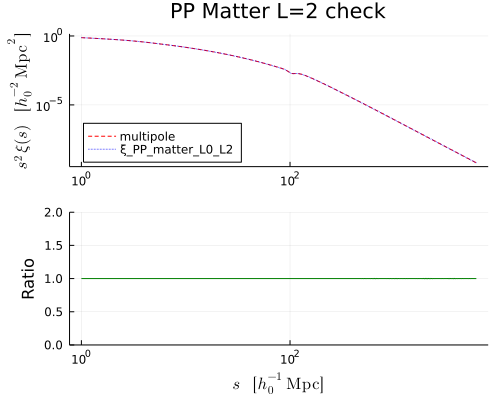

In [27]:
xs_1 = ss_ppm_L2_noF
ys_1 = xis_ppm_L2_noF 
spline = Spline1D(xs_1, ys_1)

xs_2 = c_ss_ppm
ys_2 = c_xi_ppm_L2

p1 = plot([xs_1, xs_2], [abs.(ys_1), abs.(ys_2)],
    xaxis=:log, yaxis=:log, legend=:bottomleft,
    lc=[:red :blue], 
    title = "PP Matter L=2 check",
    label=["multipole" "ξ_PP_matter_L0_L2"], ls=[:dash :dot], 
    ylabel = L"s^2 \, \xi(s) \quad [h_0^{-2} \,\mathrm{Mpc}^{2}]")
p2 = plot(xs_2, spline.(xs_2) ./ ys_2, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log, ylim=(0,2), legend=false, 
    xlabel=L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$")

P = plot(p1, p2, size=(500, 400), layout= @layout [ x ; z ] )

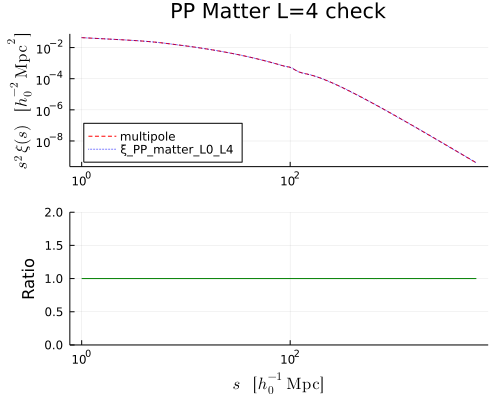

In [28]:
xs_1 = ss_ppm_L4_noF
ys_1 = xis_ppm_L4_noF 
spline = Spline1D(xs_1, ys_1)

xs_2 = c_ss_ppm
ys_2 = c_xi_ppm_L4

p1 = plot([xs_1, xs_2], [abs.(ys_1), abs.(ys_2)],
    xaxis=:log, yaxis=:log, legend=:bottomleft,
    lc=[:red :blue], 
    title = "PP Matter L=4 check",
    label=["multipole" "ξ_PP_matter_L0_L4"], ls=[:dash :dot], 
    ylabel = L"s^2 \, \xi(s) \quad [h_0^{-2} \,\mathrm{Mpc}^{2}]")
p2 = plot(xs_2, spline.(xs_2) ./ ys_2, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log, ylim=(0,2), legend=false, 
    xlabel=L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$")

P = plot(p1, p2, size=(500, 400), layout= @layout [ x ; z ] )

## Check Plots

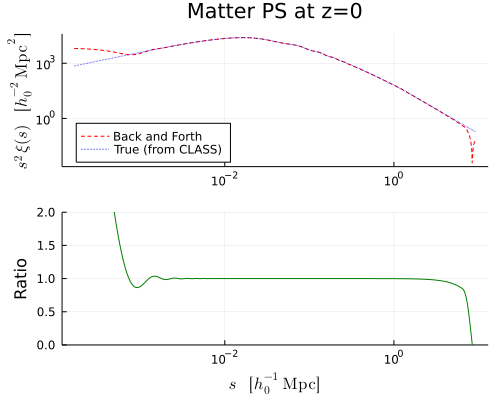

In [29]:
xs_1 = ks_matter_L0
ys_1 = pks_matter_L0 
spline = Spline1D(xs_1, ys_1)

xs_2 = ks_matter_L0
ys_2 = [cosmo.IPS(k) for k in xs_2 ]


S_VLIM = 8
S_VLIM_F = @sprintf("%.2f", S_VLIM)

p1 = plot([xs_1, xs_2], [abs.(ys_1), abs.(ys_2)],
    xaxis=:log, yaxis=:log, legend=:bottomleft,
    lc=[:red :blue], 
    title = "Matter PS at z=0",
    label=["Back and Forth" "True (from CLASS)"], ls=[:dash :dot], 
    ylabel = L"s^2 \, \xi(s) \quad [h_0^{-2} \,\mathrm{Mpc}^{2}]")
#vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_2, spline.(xs_2) ./ ys_2, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log, ylim=(0,2), legend=false, 
    xlabel=L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$")
#vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, size=(500, 400), layout= @layout [ x ; z ] )
#savefig(P, "PS_AutoDoppler_L0.pdf")
#display(P)

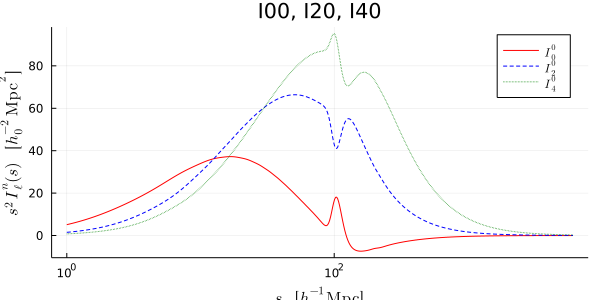

In [30]:
xs_1 = ss_ppm_L0_noF
xs_2 = ss_ppm_L2_noF
xs_3 = ss_ppm_L4_noF

ys_1 = [cosmo.tools.I00(s) for s in xs_1] .* xs_1 .^2
ys_2 = [cosmo.tools.I20(s) for s in xs_2] .* xs_2 .^2
ys_3 = [cosmo.tools.I40(s) for s in xs_3] .* xs_3 .^2

p1 = plot(xs_1, ys_1,
    xaxis=:log, #yaxis=:log, 
    lc=:red, title = "I00, I20, I40",
    label=L"I_0^0", ls=:solid, legend=:topright, size=(600, 300),
    ylabel = L"s^2 \, I_{\ell}^n(s) \quad [h_0^{-2} \,\mathrm{Mpc}^{2}]",
    xlabel = L"s \quad [h_0^{-1} \mathrm{Mpc}]")
plot!(p1, xs_2, ys_2, label = L"I_{2}^0", ls=:dash, lc =:blue)
plot!(p1, xs_3, ys_3, label = L"I_4^0", ls=:dot, lc =:green)

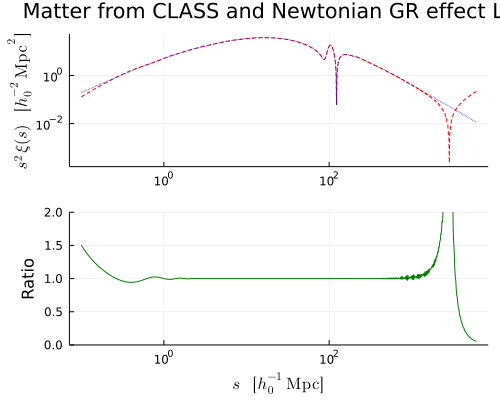

In [31]:
xs_1 = ss_matter_L0
ys_1 = abs.(xis_matter_L0 .* xs_1 .^2)

#xs_2 = ss_GNC_L0_withF
#ys_2 = 2.0 .* abs.(all_xis_GNC_L0_withF[1] .* xs_2 .^2)
xs_2 = ss_matter_L0
ys_2 = abs.([cosmo.tools.I00(s) for s in xs_2] .* xs_2 .^2)
spline = Spline1D(xs_2, ys_2)

S_VLIM = 8
S_VLIM_F = @sprintf("%.2f", S_VLIM)

p1 = plot([xs_1[ys_1.≠0], xs_2[ys_2.≠0]], [ys_1[ys_1.≠0], ys_2[ys_2.≠0]],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], 
    title = "Matter from CLASS and Newtonian GR effect L=0",
    label=["Matter (from CLASS)" "2*GNC Newtonian GR effect L=0"], ls=[:dash :dot], 
    ylabel = L"s^2 \, \xi(s) \quad [h_0^{-2} \,\mathrm{Mpc}^{2}]",
    legend=false)
#vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log,
    ylim=(0.0,2), 
    legend=false, 
    xlabel=L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$")
#vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, size=(500, 400), layout= @layout [ x ; z ] )
#savefig(P, "PS_AutoDoppler_L0.pdf")
#display(P)

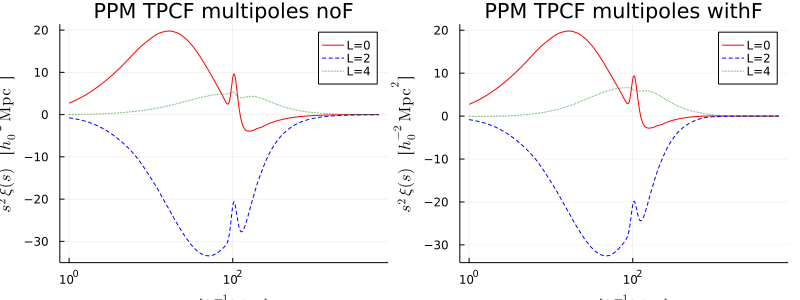

In [32]:
xs_1 = ss_ppm_L0_noF
xs_2 = ss_ppm_L2_noF
xs_3 = ss_ppm_L4_noF

ys_1 = xis_ppm_L0_noF .* xs_1 .^2
ys_2 = xis_ppm_L2_noF .* xs_1 .^2
ys_3 = xis_ppm_L4_noF .* xs_1 .^2

xs_4 = ss_ppm_L0_withF
xs_5 = ss_ppm_L2_withF
xs_6 = ss_ppm_L4_withF

ys_4 = xis_ppm_L0_withF .* xs_4 .^2
ys_5 = xis_ppm_L2_withF .* xs_5 .^2
ys_6 = xis_ppm_L4_withF .* xs_6 .^2

p1 = plot(xs_1, ys_1,
    xaxis=:log, #yaxis=:log, 
    lc=:red, title = "PPM TPCF multipoles noF",
    label="L=0", ls=:solid, legend=:topright,
    ylabel = L"s^2 \, \xi(s) \quad [h_0^{-2} \,\mathrm{Mpc}^{2}]",
    xlabel = L"s \quad [h_0^{-1} \mathrm{Mpc}]")
plot!(p1, xs_2, ys_2, label = "L=2", ls=:dash, lc =:blue)
plot!(p1, xs_3, ys_3, label = "L=4", ls=:dot, lc =:green)

p2 = plot(xs_4, ys_4,
    xaxis=:log, #yaxis=:log, 
    lc=:red, title = "PPM TPCF multipoles withF",
    label="L=0", ls=:solid, legend=:topright,
    ylabel = L"s^2 \, \xi(s) \quad [h_0^{-2} \,\mathrm{Mpc}^{2}]",
    xlabel = L"s \quad [h_0^{-1} \mathrm{Mpc}]")
plot!(p2, xs_5, ys_5, label = "L=2", ls=:dash, lc =:blue)
plot!(p2, xs_6, ys_6, label = "L=4", ls=:dot, lc =:green)

plot(p1, p2, size=(800, 300))

In [33]:
xs_1 = ss_matter_L0
ys_1 = xis_matter_L0 .* xs_1 .^2
spline = Spline1D(xs_1, ys_1)

xs_2 = ss_ppm_L0_noF
ys_2 = [spline_xi_ppm_L0_noF(s) for s in xs_2 ] .* xs_2 .^2


S_VLIM = 8
S_VLIM_F = @sprintf("%.2f", S_VLIM)

p1 = plot([xs_1, xs_2], [abs.(ys_1), abs.(ys_2)],
    xaxis=:log, yaxis=:log, legend=:bottomleft,
    lc=[:red :blue], 
    title = "Matter TPCF",
    label=["True (from CLASS)" "sum multipoles PP"], ls=[:dash :dot], 
    ylabel = L"s^2 \, \xi(s) \quad [h_0^{-2} \,\mathrm{Mpc}^{2}]")
#vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_2, spline.(xs_2) ./ ys_2, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log, ylim=(0,2), legend=false, 
    xlabel=L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$")
#vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, size=(500, 400), layout= @layout [ x ; z ] )
#savefig(P, "PS_AutoDoppler_L0.pdf")
#display(P)

LoadError: UndefVarError: spline_xi_ppm_L0_noF not defined

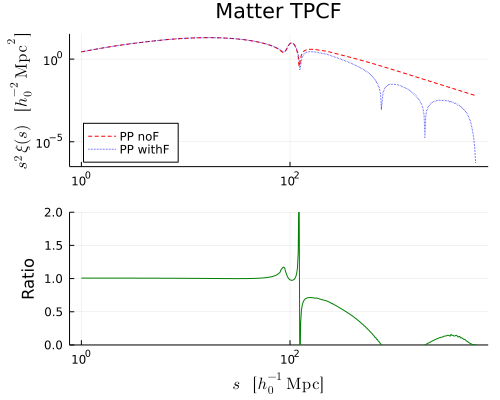

In [34]:
xs_1 = ss_ppm_L0_noF
ys_1 = xis_ppm_L0_noF .* xs_1 .^2

xs_2 = ss_ppm_L0_withF[xis_ppm_L0_withF .≠ 0]
ys_2 = xis_ppm_L0_withF[xis_ppm_L0_withF .≠ 0] .* xs_2 .^2
spline = Spline1D(xs_2, ys_2)


S_VLIM = 8
S_VLIM_F = @sprintf("%.2f", S_VLIM)

p1 = plot([xs_1, xs_2], [abs.(ys_1), abs.(ys_2)],
    xaxis=:log, yaxis=:log, legend=:bottomleft,
    lc=[:red :blue], 
    title = "Matter TPCF",
    label=["PP noF" "PP withF"], ls=[:dash :dot], 
    ylabel = L"s^2 \, \xi(s) \quad [h_0^{-2} \,\mathrm{Mpc}^{2}]")
#vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log, ylim=(0,2), legend=false, 
    xlabel=L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$")
#vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, size=(500, 400), layout= @layout [ x ; z ] )
#savefig(P, "PS_AutoDoppler_L0.pdf")
#display(P)

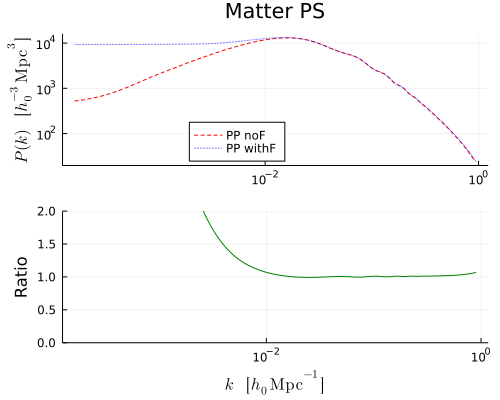

In [35]:
xs_1 = ks_ppm_L0_noF
ys_1 = abs.(pks_ppm_L0_noF)

xs_2 = ks_ppm_L0_withF
ys_2 = abs.(pks_ppm_L0_withF)
spline = Spline1D(xs_2, ys_2)

S_VLIM = 8
S_VLIM_F = @sprintf("%.2f", S_VLIM)

p1 = plot([xs_1, xs_2], [ys_1, ys_2],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], 
    title = "Matter PS",
    label=["PP noF" "PP withF"], ls=[:dash :dot], 
    ylabel = L"P(k) \quad [h_0^{-3} \,\mathrm{Mpc}^{3}]",
    legend=:bottom)
#vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log, ylim=(0,2), legend=false, 
    xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$")
#vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, size=(500, 400), layout= @layout [ x ; z ] )
#savefig(P, "PS_AutoDoppler_L0.pdf")
#display(P)

## All GR effects TPCFs computation (no F)

In [36]:
#=
GaPSE.print_map_sum_ξ_LD_multipole(
    cosmo, DIR*"map_sum_xis_LD_L0_noF.txt", 
    10 .^ range(0, log10(2*cosmo.s_max), length = 500);
    single = true, use_windows = false, enhancer = 1e8, L=0,
    N_μs = 200, μ_atol = 0.0, μ_rtol = 1e-2, trap = true,
    N_χs = 100, N_χs_2 = 60);
=#

In [37]:
#=
GaPSE.print_map_sum_ξ_GNC_multipole(
    cosmo, DIR*"map_sum_xis_GNC_L0_noF.txt", 
    10 .^ range(0, log10(2*cosmo.s_max), length = 500);
    single = true, use_windows = false, enhancer = 1e8, L=0,
    N_μs = 200, μ_atol = 0.0, μ_rtol = 1e-2, trap = true,
    N_χs = 100, N_χs_2 = 60);
=#

In [38]:
#=
GaPSE.print_map_sum_ξ_GNCxLD_multipole(
    cosmo, DIR*"map_sum_xis_GNCxLD_L0_noF.txt", 
    10 .^ range(0, log10(2*cosmo.s_max), length = 500);
    single = true, use_windows = false, enhancer = 1e8, L=0,
    N_μs = 200, μ_atol = 0.0, μ_rtol = 1e-2, trap = true,
    N_χs = 100, N_χs_2 = 60);
=#

In [39]:
#=
GaPSE.print_map_sum_ξ_LDxGNC_multipole(
    cosmo, DIR*"map_sum_xis_LDxGNC_L0_noF.txt", 
   10 .^ range(0, log10(2*cosmo.s_max), length = 500);
    single = true, use_windows = false, enhancer = 1e8, L=0,
    N_μs = 200, μ_atol = 0.0, μ_rtol = 1e-2, trap = true,
    N_χs = 100, N_χs_2 = 60);
=#

In [40]:
#=
GaPSE.print_map_sum_ξ_LD_multipole(
    cosmo, DIR*"map_sum_xis_LD_L2_noF.txt", 
    10 .^ range(0, log10(2*cosmo.s_max), length = 500);
    single = true, use_windows = false, enhancer = 1e8, L=2,
    N_μs = 200, μ_atol = 0.0, μ_rtol = 1e-2, trap = true,
    N_χs = 100, N_χs_2 = 60);
=#

In [41]:
#=
GaPSE.print_map_sum_ξ_GNC_multipole(
    cosmo, DIR*"map_sum_xis_GNC_L2_noF.txt", 
    10 .^ range(0, log10(2*cosmo.s_max), length = 500);
    single = true, use_windows = false, enhancer = 1e8, L=2,
    N_μs = 200, μ_atol = 0.0, μ_rtol = 1e-2, trap = true,
    N_χs = 100, N_χs_2 = 60);
=#

In [42]:
#=
GaPSE.print_map_sum_ξ_GNCxLD_multipole(
    cosmo, DIR*"map_sum_xis_GNCxLD_L2_noF.txt", 
    10 .^ range(0, log10(2*cosmo.s_max), length = 500);
    single = true, use_windows = false, enhancer = 1e8, L=2,
    N_μs = 200, μ_atol = 0.0, μ_rtol = 1e-2, trap = true,
    N_χs = 100, N_χs_2 = 60);
=#

In [43]:
#=
GaPSE.print_map_sum_ξ_LDxGNC_multipole(
    cosmo, DIR*"map_sum_xis_LDxGNC_L2_noF.txt", 
    10 .^ range(0, log10(2*cosmo.s_max), length = 500);
    single = true, use_windows = false, enhancer = 1e8, L=2,
    N_μs = 200, μ_atol = 0.0, μ_rtol = 1e-2, trap = true,
    N_χs = 100, N_χs_2 = 60);
=#

In [44]:
ss_LD_L0_noF, xis_sum_LD_L0_noF, all_xis_LD_L0_noF = GaPSE.readxyall(DIR*"map_sum_xis_LD_L0_noF.txt");
ss_GNC_L0_noF, xis_sum_GNC_L0_noF, all_xis_GNC_L0_noF = GaPSE.readxyall(DIR*"map_sum_xis_GNC_L0_noF.txt");
ss_GNCxLD_L0_noF, xis_sum_GNCxLD_L0_noF, all_xis_GNCxLD_L0_noF = GaPSE.readxyall(DIR*"map_sum_xis_GNCxLD_L0_noF.txt");
ss_LDxGNC_L0_noF, xis_sum_LDxGNC_L0_noF, all_xis_LDxGNC_L0_noF = GaPSE.readxyall(DIR*"map_sum_xis_LDxGNC_L0_noF.txt");

spline_LD_sum_L0_noF = Spline1D(ss_LD_L0_noF, xis_sum_LD_L0_noF; bc = "error");
spline_GNC_sum_L0_noF = Spline1D(ss_GNC_L0_noF, xis_sum_GNC_L0_noF; bc = "error");
spline_GNCxLD_sum_L0_noF = Spline1D(ss_GNCxLD_L0_noF, xis_sum_GNCxLD_L0_noF; bc = "error");
spline_LDxGNC_sum_L0_noF = Spline1D(ss_LDxGNC_L0_noF, xis_sum_LDxGNC_L0_noF; bc = "error");

In [45]:
ss_sum_noF = ss_LD_L0_noF;
xis_sum_noF = [spline_LD_sum_L0_noF(s) + spline_GNC_sum_L0_noF(s) + 
        spline_GNCxLD_sum_L0_noF(s) + spline_LDxGNC_sum_L0_noF(s)
        for s in ss_sum_noF];

open(DIR*"xi_ALL_GR_TPCF_SUMMED_noF.txt", "w") do io
    println(io, GaPSE.BRAND)
    println(io, "# This is the sum of all the GR effects TPCFs without window F:")
    println(io, "# LD (16), GNC (25), GNCxLD (20), LDxGNC (20)\n#")
    GaPSE.parameters_used(io, cosmo; logo=false)
    println(io, "# s [Mpc/h_0] \t xi_ALLSUMMED_noF")
    for (s,xi) in zip(ss_sum_noF, xis_sum_noF)
        println(io, "$s \t $xi")
    end
end

GaPSE.print_PS_multipole(DIR*"xi_ALL_GR_TPCF_SUMMED_noF.txt", 
    DIR*"ps_ALL_GR_TPCF_SUMMED_noF.txt"; 
    L = 0,  ps_kwargs(tf)...);


I'm computing the PS_multipole from the file "Effective_fNL_z115_files/xi_ALL_GR_TPCF_SUMMED_noF.txt" 


LoadError: DomainError with -0.07531330573237227:
log will only return a complex result if called with a complex argument. Try log(Complex(x)).

In [46]:
ks_sum_noF, pks_sum_noF = GaPSE.readxy(DIR*"ps_ALL_GR_TPCF_SUMMED_noF.txt");

LoadError: ArgumentError: Cannot open 'Effective_fNL_z115_files/ps_ALL_GR_TPCF_SUMMED_noF.txt': not a file

## All GR effects TPCFs computation (with F)

In [47]:
#=
GaPSE.print_map_sum_ξ_LD_multipole(
    cosmo, DIR*"map_sum_xis_LD_L0_withF.txt", 
    10 .^ range(0, log10(2*cosmo.s_max), length = 500);
    single = true, use_windows = true, enhancer = 1e8, L=0,
    N_μs = 200, μ_atol = 0.0, μ_rtol = 1e-2, trap = true,
    N_χs = 100, N_χs_2 = 60);
=#

In [48]:
#=
GaPSE.print_map_sum_ξ_GNC_multipole(
    cosmo, DIR*"map_sum_xis_GNC_L0_withF.txt", 
    10 .^ range(0, log10(2*cosmo.s_max), length = 500);
    single = true, use_windows = true, enhancer = 1e8, L=0,
    N_μs = 200, μ_atol = 0.0, μ_rtol = 1e-2, trap = false,
    N_χs = 100, N_χs_2 = 60);
=#

In [49]:
#=
GaPSE.print_map_sum_ξ_GNCxLD_multipole(
    cosmo, DIR*"map_sum_xis_GNCxLD_L0_withF.txt", 
    10 .^ range(0, log10(2*cosmo.s_max), length = 500);
    single = true, use_windows = true, enhancer = 1e8, L=0,
    N_μs = 200, μ_atol = 0.0, μ_rtol = 1e-2, trap = false,
    N_χs = 100, N_χs_2 = 60);
=#

In [50]:
#=
GaPSE.print_map_sum_ξ_LDxGNC_multipole(
    cosmo, DIR*"map_sum_xis_LDxGNC_L0_withF.txt", 
   10 .^ range(0, log10(2*cosmo.s_max), length = 500);
    single = true, use_windows = true, enhancer = 1e8, L=0,
    N_μs = 200, μ_atol = 0.0, μ_rtol = 1e-2, trap = true,
    N_χs = 100, N_χs_2 = 60);
=#

In [91]:
ss_LD_L0_withF, xis_sum_LD_L0_withF, all_xis_LD_L0_withF = 
    GaPSE.readxyall(DIR*"map_sum_xis_LD_L0_withF.txt");
ss_GNC_L0_withF, xis_sum_GNC_L0_withF, all_xis_GNC_L0_withF = 
    GaPSE.readxyall(DIR*"map_sum_xis_GNC_L0_withF.txt");
ss_GNCxLD_L0_withF, xis_sum_GNCxLD_L0_withF, all_xis_GNCxLD_L0_withF = 
    GaPSE.readxyall(DIR*"map_sum_xis_GNCxLD_L0_withF.txt");
ss_LDxGNC_L0_withF, xis_sum_LDxGNC_L0_withF, all_xis_LDxGNC_L0_withF = 
    GaPSE.readxyall(DIR*"map_sum_xis_LDxGNC_L0_withF.txt");

spline_LD_sum_L0_withF = Spline1D(ss_LD_L0_withF, xis_sum_LD_L0_withF; bc = "error");
spline_GNC_sum_L0_withF = Spline1D(ss_GNC_L0_withF, xis_sum_GNC_L0_withF; bc = "error");
spline_GNCxLD_sum_L0_withF = Spline1D(ss_GNCxLD_L0_withF, xis_sum_GNCxLD_L0_withF; bc = "error");
spline_LDxGNC_sum_L0_withF = Spline1D(ss_LDxGNC_L0_withF, xis_sum_LDxGNC_L0_withF; bc = "error");

In [92]:
ss_GRsum_L0_withF = ss_LD_L0_withF;
xis_GRsum_L0_withF = [spline_LD_sum_L0_withF(s) + spline_GNC_sum_L0_withF(s) + 
        spline_GNCxLD_sum_L0_withF(s) + spline_LDxGNC_sum_L0_withF(s)
        for s in ss_GRsum_L0_withF];

open(DIR*"xi_ALL_GR_TPCF_SUMMED_L0_withF.txt", "w") do io
    println(io, GaPSE.BRAND)
    println(io, "# This is the sum of all the GR effects TPCFs (with window):")
    println(io, "# LD (16), GNC (25), GNCxLD (20), LDxGNC (20)\n#")
    GaPSE.parameters_used(io, cosmo; logo=false)
    println(io, "# s [Mpc/h_0] \t xi_ALLSUMMED")
    for (s,xi) in zip(ss_GRsum_L0_withF, xis_GRsum_L0_withF)
        println(io, "$s \t $xi")
    end
end

GaPSE.print_PS_multipole(DIR*"xi_ALL_GR_TPCF_SUMMED_L0_withF.txt", 
    DIR*"ps_ALL_GR_TPCF_SUMMED_L0_withF.txt"; 
    L = 0,  ps_kwargs(tf)...);
ks_GRsum_L0_withF, pks_GRsum_L0_withF = GaPSE.readxy(DIR*"ps_ALL_GR_TPCF_SUMMED_L0_withF.txt");


I'm computing the PS_multipole from the file "Effective_fNL_z115_files/xi_ALL_GR_TPCF_SUMMED_L0_withF.txt" 

time needed for this Power Spectrum computation [in s] = 0.0013430118560791016



In [102]:
ss_Newt_L0_withF, xis_Newt_L0_withF = 
    GaPSE.map_ξ_GNC_multipole(cosmo, 
    "auto_newton",
    10 .^ range(0,log10(2*cosmo.s_max),length=1000);
    L = 0, use_windows = true, pr = true, enhancer = 1e6,
    μ_atol = 0.0, μ_rtol = 1e-2);

ks_Newtonian_L0_withF, pks_Newtonian_L0_withF = GaPSE.PS_multipole(ss_Newt_L0_withF, 
    xis_Newt_L0_withF; L = 0,  ps_kwargs(tf)...);

auto_newton, L=0: 100%|█████████████████████████████████| Time: 0:00:06



time needed for map_ξ_GNC_multipole for auto_newton [in s] = 6.97508 


time needed for this Power Spectrum computation [in s] = 0.0016911029815673828



In [103]:
#ks_Newtonian_L0_withF, pks_Newtonian_L0_withF = GaPSE.PS_multipole(ss_GNC_L0_withF, 
#    all_xis_GNC_L0_withF[1]; L = 0,  ps_kwargs(tf)...);

## Plots

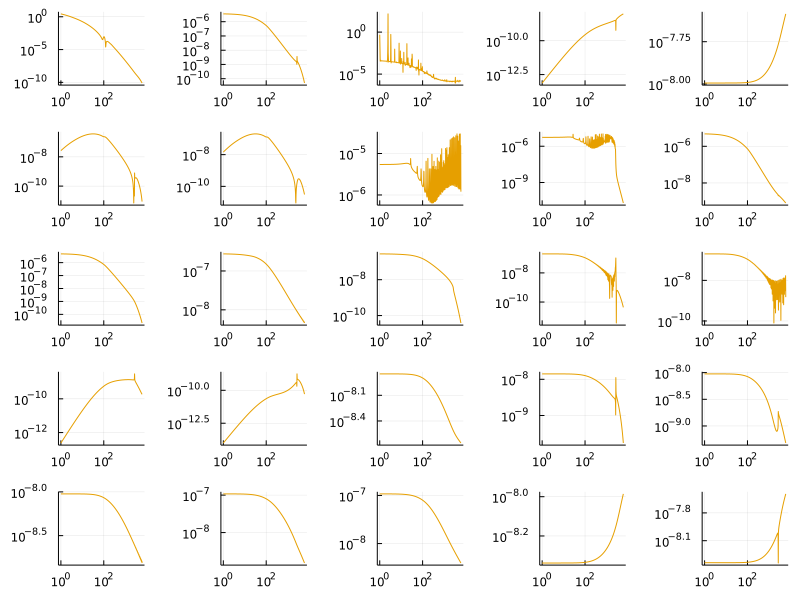

In [55]:
vec = all_xis_GNC_L0_noF
ALL_PLOTS = [plot() for i in 1:length(vec)]

for i in 1:length(vec)
   ALL_PLOTS[i] = plot(ss_GNC_L0_noF, abs.(vec[i]), axis=:log, label=false)
end

plot(ALL_PLOTS..., size=(800, 600))

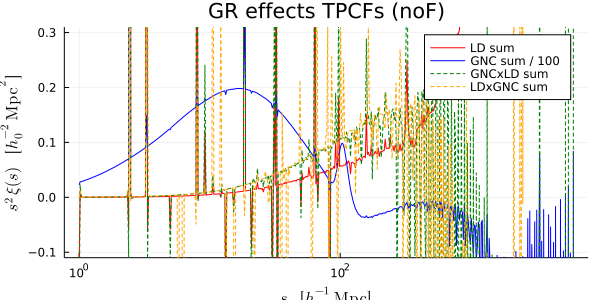

In [56]:
xs_1 = ss_LD_L0_noF
ys_1 = xis_sum_LD_L0_noF .* xs_1 .^2

xs_2 = ss_GNC_L0_noF
ys_2 = xis_sum_GNC_L0_noF .* xs_2 .^2 ./100

xs_3 = ss_GNCxLD_L0_noF
ys_3 = xis_sum_GNCxLD_L0_noF .* xs_3 .^2

xs_4 = ss_LDxGNC_L0_noF
ys_4 = xis_sum_LDxGNC_L0_noF .* xs_4 .^2

S_VLIM = 8
S_VLIM_F = @sprintf("%.2f", S_VLIM)

p1 = plot(xs_1, ys_1,
    xaxis=:log, #yaxis=:log, 
    lc=:red, title = "GR effects TPCFs (noF)", ylims =(-0.11, 0.31),
    label="LD sum", ls=:solid, legend=:topright, size=(600, 300),
    ylabel = L"s^2 \, \xi(s) \quad [h_0^{-2} \,\mathrm{Mpc}^{2}]",
    xlabel = L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$")
plot!(p1, xs_2, ys_2, label = "GNC sum / 100", ls=:solid, lc =:blue)
plot!(p1, xs_3, ys_3, label = "GNCxLD sum", ls=:dash, lc =:green)
plot!(p1, xs_4, ys_4, label = "LDxGNC sum", ls=:dash, lc =:orange)
#vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

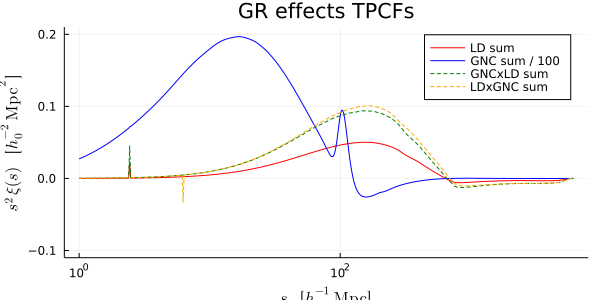

In [57]:
xs_1 = ss_LD_L0_withF
ys_1 = xis_sum_LD_L0_withF .* xs_1 .^2

xs_2 = ss_GNC_L0_withF
ys_2 = xis_sum_GNC_L0_withF .* xs_2 .^2 ./100

xs_3 = ss_GNCxLD_L0_withF
ys_3 = xis_sum_GNCxLD_L0_withF .* xs_3 .^2

xs_4 = ss_LDxGNC_L0_withF
ys_4 = xis_sum_LDxGNC_L0_withF .* xs_4 .^2

S_VLIM = 8
S_VLIM_F = @sprintf("%.2f", S_VLIM)

p1 = plot(xs_1, ys_1,
    xaxis=:log, #yaxis=:log, 
    lc=:red, title = "GR effects TPCFs", ylims =(-0.11, 0.21),
    label="LD sum", ls=:solid, legend=:topright, size=(600, 300),
    ylabel = L"s^2 \, \xi(s) \quad [h_0^{-2} \,\mathrm{Mpc}^{2}]",
    xlabel = L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$")
plot!(p1, xs_2, ys_2, label = "GNC sum / 100", ls=:solid, lc =:blue)
plot!(p1, xs_3, ys_3, label = "GNCxLD sum", ls=:dash, lc =:green)
plot!(p1, xs_4, ys_4, label = "LDxGNC sum", ls=:dash, lc =:orange)
#vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

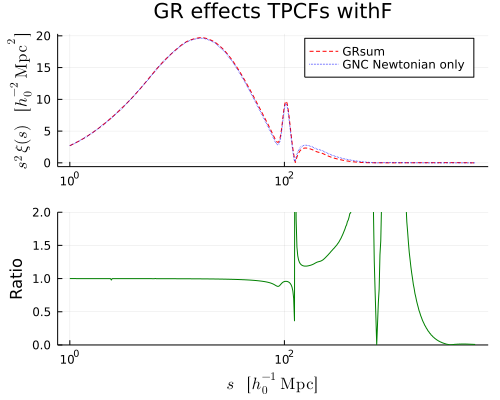

In [58]:
xs_1 = ss_GRsum_L0_withF
ys_1 = abs.(xis_GRsum_L0_withF .* xs_1 .^2)

xs_2 = ss_GNC_L0_withF
ys_2 = abs.(all_xis_GNC_L0_withF[1] .* xs_2 .^2)
spline = Spline1D(xs_2, ys_2)

S_VLIM = 8
S_VLIM_F = @sprintf("%.2f", S_VLIM)

p1 = plot([xs_1, xs_2], [ys_1, ys_2],
    xaxis=:log, #yaxis=:log, 
    lc=[:red :blue], 
    title = "GR effects TPCFs withF",
    label=["GRsum" "GNC Newtonian only"], ls=[:dash :dot], 
    ylabel = L"s^2 \, \xi(s) \quad [h_0^{-2} \,\mathrm{Mpc}^{2}]",
    legend=:topright)
#vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log,
    ylim=(0.0,2), 
    legend=false, 
    xlabel=L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$")
#vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, size=(500, 400), layout= @layout [ x ; z ] )
#savefig(P, "PS_AutoDoppler_L0.pdf")
#display(P)

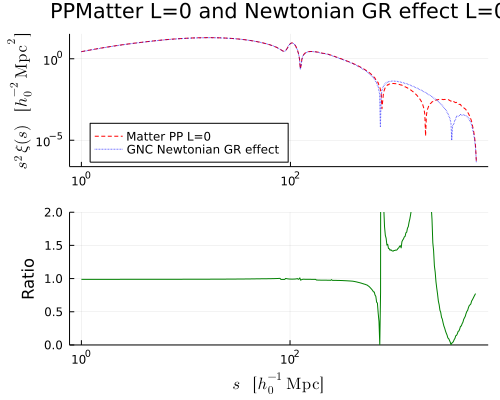

In [59]:
xs_1 = ss_ppm_L0_withF
ys_1 = abs.(xis_ppm_L0_withF .* xs_1 .^2)

xs_2 = ss_GNC_L0_withF
ys_2 = abs.(all_xis_GNC_L0_withF[1] .* xs_2 .^2)
spline = Spline1D(xs_2, ys_2)

S_VLIM = 8
S_VLIM_F = @sprintf("%.2f", S_VLIM)

p1 = plot([xs_1[ys_1.≠0], xs_2[ys_2.≠0]], [ys_1[ys_1.≠0], ys_2[ys_2.≠0]],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], 
    title = "PPMatter L=0 and Newtonian GR effect L=0",
    label=["Matter PP L=0" "GNC Newtonian GR effect"], ls=[:dash :dot], 
    ylabel = L"s^2 \, \xi(s) \quad [h_0^{-2} \,\mathrm{Mpc}^{2}]",
    legend=:bottom)
#vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log,
    ylim=(0.0,2), 
    legend=false, 
    xlabel=L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$")
#vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, size=(500, 400), layout= @layout [ x ; z ] )
#savefig(P, "PS_AutoDoppler_L0.pdf")
#display(P)

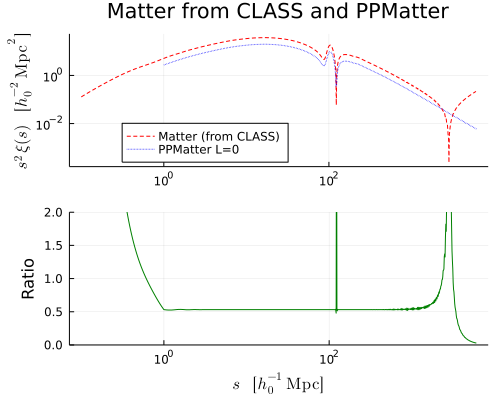

In [60]:
xs_1 = ss_matter_L0
ys_1 = abs.(xis_matter_L0 .* xs_1 .^2)

xs_2 = ss_ppm_L0_noF
ys_2 = abs.(xis_ppm_L0_noF) .* xs_2 .^2
spline = Spline1D(xs_2, ys_2)

S_VLIM = 8
S_VLIM_F = @sprintf("%.2f", S_VLIM)

p1 = plot([xs_1[ys_1.≠0], xs_2[ys_2.≠0]], [ys_1[ys_1.≠0], ys_2[ys_2.≠0]],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], 
    title = "Matter from CLASS and PPMatter",
    label=["Matter (from CLASS)" "PPMatter L=0"], ls=[:dash :dot], 
    ylabel = L"s^2 \, \xi(s) \quad [h_0^{-2} \,\mathrm{Mpc}^{2}]",
    legend=:bottom)
#vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log,
    ylim=(0.0,2), 
    legend=false, 
    xlabel=L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$")
#vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, size=(500, 400), layout= @layout [ x ; z ] )
#savefig(P, "PS_AutoDoppler_L0.pdf")
#display(P)

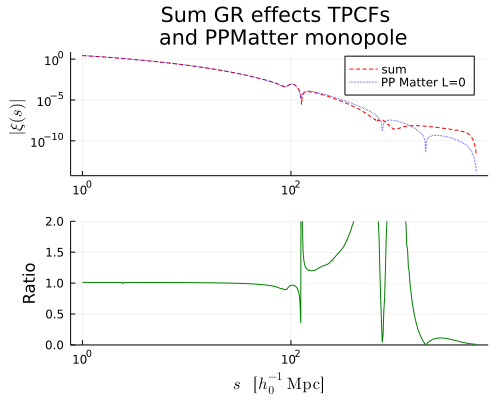

In [61]:
xs_1 = ss_GRsum_L0_withF[xis_GRsum_L0_withF .≠ 0]
ys_1 = abs.(xis_GRsum_L0_withF)[xis_GRsum_L0_withF .≠ 0]

xs_2 = ss_ppm_L0_withF[xis_ppm_L0_withF .≠ 0]
ys_2 = abs.(xis_ppm_L0_withF)[xis_ppm_L0_withF .≠ 0]
spline = Spline1D(xs_2, ys_2)

S_VLIM = 8
S_VLIM_F = @sprintf("%.2f", S_VLIM)

p1 = plot([xs_1, xs_2], [ys_1, ys_2],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], 
    title = "Sum GR effects TPCFs \n and PPMatter monopole",
    label=["sum" "PP Matter L=0"], ls=[:dash :dot], 
    ylabel = L"|\xi(s)|",
    legend=:topright)
#vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log,
    ylim=(0.0,2), 
    legend=false, 
    xlabel=L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$")
#vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, size=(500, 400), layout= @layout [ x ; z ] )
#savefig(P, "PS_AutoDoppler_L0.pdf")
#display(P)

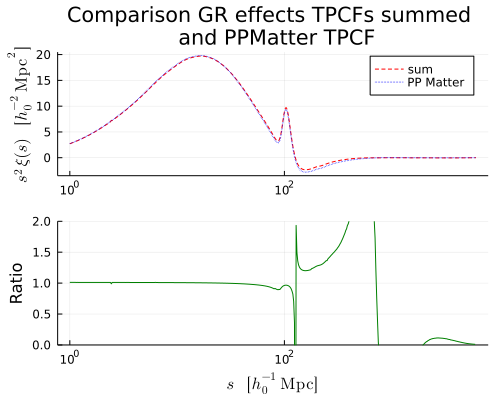

In [62]:
xs_1 = ss_GRsum_L0_withF
ys_1 = xis_GRsum_L0_withF .* xs_1 .^ 2

xs_2 = ss_ppm_L0_withF
ys_2 = xis_ppm_L0_withF .* xs_2 .^ 2
spline = Spline1D(xs_2, ys_2)

S_VLIM = 8
S_VLIM_F = @sprintf("%.2f", S_VLIM)

p1 = plot([xs_1, xs_2], [ys_1, ys_2],
    xaxis=:log, #yaxis=:log, 
    lc=[:red :blue], 
    title = "Comparison GR effects TPCFs summed \n and PPMatter TPCF",
    label=["sum" "PP Matter"], ls=[:dash :dot], 
    ylabel = L"s^2 \, \xi(s) \quad [h_0^{-2} \,\mathrm{Mpc}^{2}]",
    legend=:topright)
#vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log,
    ylim=(0.0,2), 
    legend=false, 
    xlabel=L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$")
#vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, size=(500, 400), layout= @layout [ x ; z ] )
#savefig(P, "PS_AutoDoppler_L0.pdf")
#display(P)

## EMERGENCY

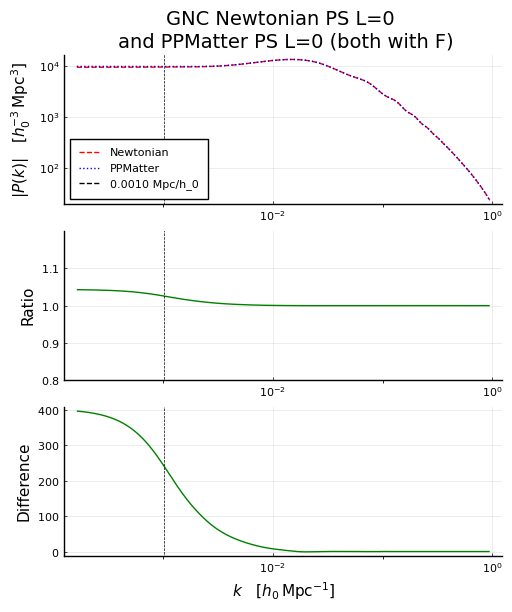

In [105]:
xs_1 = ks_ppm_L0_withF
ys_1 = pks_ppm_L0_withF

xs_2 = ks_Newtonian_L0_withF
ys_2 = pks_Newtonian_L0_withF
spline = Spline1D(xs_2, ys_2)

S_VLIM = 2*π/(2*cosmo.s_max)
S_VLIM_F = @sprintf("%.4f", S_VLIM)

p1 = plot([xs_1, xs_2], [abs.(ys_1), abs.(ys_2)],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], yticks = 10.0 .^ [i for i in 2:5],
    title = "GNC Newtonian PS L=0 \n and PPMatter PS L=0 (both with F)",
    label=["Newtonian" "PPMatter"], ls=[:dash :dot], 
    ylabel = L"|P(k)| \quad [h_0^{-3}\,\mathrm{Mpc}^3]",
    legend=:bottomleft)
vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log, 
    ylim=(0.8,1.2), 
    legend=false, 
    #xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$",
    )
vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p3 = plot(xs_1, spline.(xs_1) .- ys_1, 
    ylabel="Difference", lc=:green, 
    xaxis=:log,
    #ylim=(0.0,2), 
    legend=false, 
    xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$")
VAXES = 4e-3
vline!(p3, [S_VLIM], label="$VAXES Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, p3, size=(500, 600), layout= @layout [ x ; y ; z ] )
savefig(P, "PS_L0_Newton-PPMatter_withF.pdf")
#display(P)

## f_NL

In [82]:
function PROVA_ξ_PP_Matter_L0(s, cosmo::GaPSE.Cosmology)
     b = cosmo.params.b
     
     Peff = GaPSE.Point(cosmo.s_eff, cosmo)
     D, f = Peff.D, Peff.f

     (b^2 + 2 * b * f / 3 + f^2 / 5) * D^2 * cosmo.ξ_matter(s)
end

PROVA_ξ_PP_Matter_L0 (generic function with 1 method)

In [83]:
ss = ks_GRsum_L0_withF;
xis = [PROVA_ξ_PP_Matter_L0(s, cosmo) for s in ss];

Peff = GaPSE.Point(cosmo.s_eff, cosmo)
b, D, F = cosmo.params.b, Peff.D, Peff.f
C = (b^2 + 2 * b * F / 3 + F^2 / 5) * D^2

0.5317508798536155

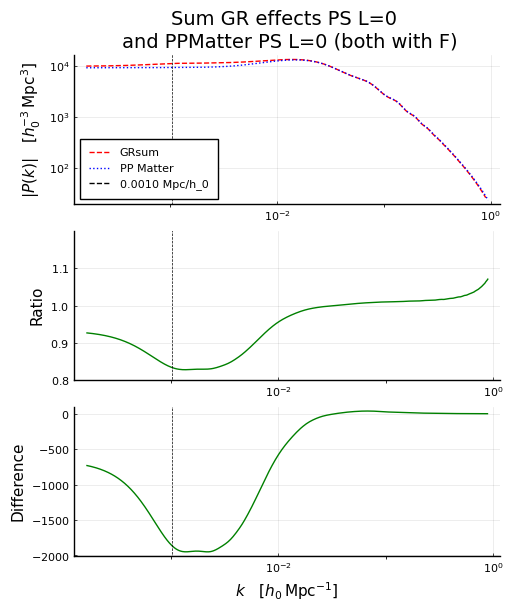

In [107]:
xs_1 = ks_GRsum_L0_withF
ys_1 = pks_GRsum_L0_withF

xs_2 = ks_ppm_L0_withF
ys_2 = pks_ppm_L0_withF
spline = Spline1D(xs_2, ys_2)

S_VLIM = 2*π/(2*cosmo.s_max)
S_VLIM_F = @sprintf("%.4f", S_VLIM)

p1 = plot([xs_1, xs_2], [abs.(ys_1), abs.(ys_2)],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], yticks = 10.0 .^ [i for i in 2:5],
    title = "Sum GR effects PS L=0 \n and PPMatter PS L=0 (both with F)",
    label=["GRsum" "PP Matter"], ls=[:dash :dot], 
    ylabel = L"|P(k)| \quad [h_0^{-3}\,\mathrm{Mpc}^3]",
    legend=:bottomleft)
vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log,
    ylim=(0.8,1.2), 
    legend=false, 
    #xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$",
    )
vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p3 = plot(xs_1, spline.(xs_1) .- ys_1, 
    ylabel="Difference", lc=:green, 
    xaxis=:log,
    #ylim=(0.0,2), 
    legend=false, 
    xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$")
VAXES = 4e-3
vline!(p3, [S_VLIM], label="$VAXES Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, p3, size=(500, 600), layout= @layout [ x ; y ; z ] )
savefig(P, "PS_L0_GRsum-PPMatter_withF.pdf")
#display(P)

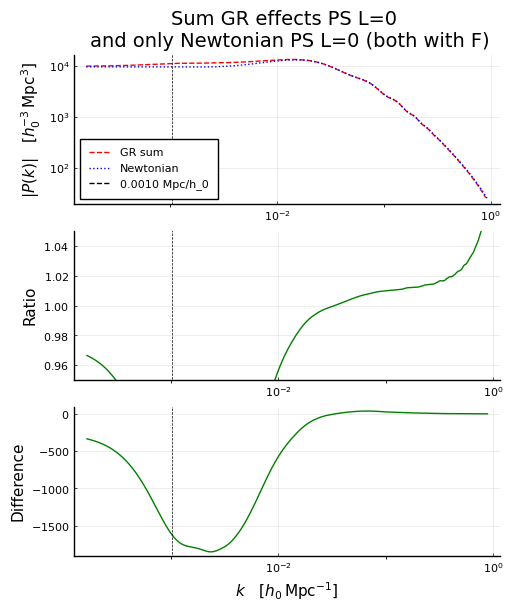

In [109]:
xs_1 = ks_GRsum_L0_withF
ys_1 = pks_GRsum_L0_withF

xs_2 = ks_Newtonian_L0_withF
ys_2 = pks_Newtonian_L0_withF
spline = Spline1D(xs_2, ys_2)

S_VLIM = 2*π/(2*cosmo.s_max)
S_VLIM_F = @sprintf("%.4f", S_VLIM)

p1 = plot([xs_1, xs_2], [abs.(ys_1), abs.(ys_2)],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], yticks = 10.0 .^ [i for i in 2:5],
    title = "Sum GR effects PS L=0 \n and only Newtonian PS L=0 (both with F)",
    label=["GR sum" "Newtonian"], ls=[:dash :dot], 
    ylabel = L"|P(k)| \quad [h_0^{-3}\,\mathrm{Mpc}^3]",
    legend=:bottomleft)
vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log, 
    ylim=(0.95,1.05), 
    legend=false, 
    #xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$",
    )
vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p3 = plot(xs_1, spline.(xs_1) .- ys_1, 
    ylabel="Difference", lc=:green, 
    xaxis=:log, 
    #ylim=(0.0,2), 
    legend=false, 
    xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$")
VAXES = 4e-3
vline!(p3, [S_VLIM], label="$VAXES Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, p3, size=(500, 600), layout= @layout [ x ; y ; z ] )
savefig(P, "PS_L0_GRsum-Newton_withF.pdf")
#display(P)

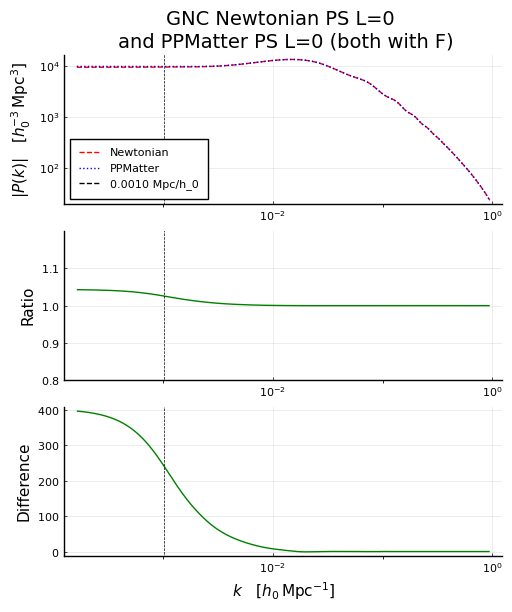

In [110]:
xs_1 = ks_ppm_L0_withF
ys_1 = pks_ppm_L0_withF

xs_2 = ks_Newtonian_L0_withF
ys_2 = pks_Newtonian_L0_withF
spline = Spline1D(xs_2, ys_2)

S_VLIM = 2*π/(2*cosmo.s_max)
S_VLIM_F = @sprintf("%.4f", S_VLIM)

p1 = plot([xs_1, xs_2], [abs.(ys_1), abs.(ys_2)],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], yticks = 10.0 .^ [i for i in 2:5],
    title = "GNC Newtonian PS L=0 \n and PPMatter PS L=0 (both with F)",
    label=["Newtonian" "PPMatter"], ls=[:dash :dot], 
    ylabel = L"|P(k)| \quad [h_0^{-3}\,\mathrm{Mpc}^3]",
    legend=:bottomleft)
vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log, 
    ylim=(0.8,1.2), 
    legend=false, 
    #xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$",
    )
vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p3 = plot(xs_1, spline.(xs_1) .- ys_1, 
    ylabel="Difference", lc=:green, 
    xaxis=:log,
    #ylim=(0.0,2), 
    legend=false, 
    xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$")
VAXES = 4e-3
vline!(p3, [S_VLIM], label="$VAXES Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, p3, size=(500, 600), layout= @layout [ x ; y ; z ] )
savefig(P, "PS_L0_Newton-PPMatter_withF.pdf")
#display(P)

## Difference studies

In [69]:
spline_ppm_L0_withF = Spline1D(ks_ppm_L0_withF, pks_ppm_L0_withF; bc = "error");
spline_GRsum_L0_withF = Spline1D(ks_GRsum_L0_withF, pks_GRsum_L0_withF; bc = "error");
spline_Newtonian_L0_withF = Spline1D(ks_Newtonian_L0_withF, pks_Newtonian_L0_withF; bc = "error");

In [70]:
ks = ks_GRsum_L0_withF
diff_Newt_ppm = [spline_Newtonian_L0_withF(k) - spline_ppm_L0_withF(k) for k in ks];
diff_ppm_GRsum = [spline_ppm_L0_withF(k) - spline_GRsum_L0_withF(k) for k in ks];
diff_Newt_GRsum = [spline_Newtonian_L0_withF(k) - spline_GRsum_L0_withF(k) for k in ks];

3 params, sigma_c and sigma_a ok
4.250351312673508e7-181103.38531280743-1662.0674859924668


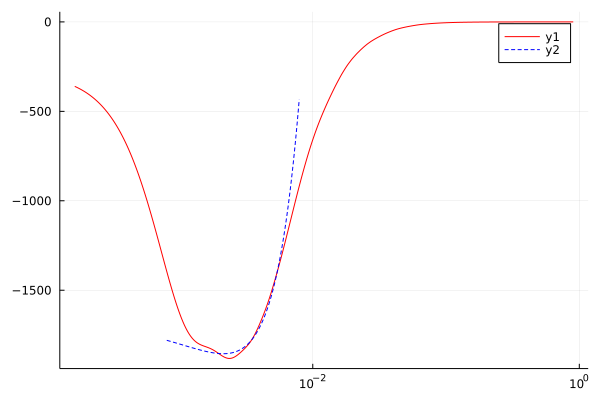

In [71]:
LIM1, LIM2 = 1.5e-3, 6e-3
LIM3, LIM4 = 0.8e-3,8e-3
c,b,a = GaPSE.polynomial_from_data(ks, diff_Newt_GRsum, [1.0, 1.0, 1.0], LIM1, LIM2)
println(c,b,a)
pls = [GaPSE.polynomial(x, c, b, a) for x in ks[LIM3 .< ks .< LIM4]]

plot(ks, diff_Newt_GRsum, lc=:red, xaxis=:log)
plot!(ks[LIM3 .< ks .< LIM4], pls, lc=:blue, ls =:dash)

In [72]:
f(x; a=1.0, b=1.0, c=1.0) = c + b*x + a*x^2;

In [73]:
LIM = 1.5e-3
c,b,a = GaPSE.polynomial_from_data(ks_GRsum_L0_withF, difference, [1.0, 1.0, 1.0], ks_GRsum_L0_withF[begin], LIM)

LoadError: UndefVarError: difference not defined

In [74]:
xs_1 = ks_GRsum_L0_withF[ks_GRsum_L0_withF .< 1e-2]
xs_2 = ks_GRsum_L0_withF[ks_GRsum_L0_withF .< 2e-3]
ys_1 = difference[ks_GRsum_L0_withF .< 1e-2]
ys_2 = [GaPSE.polynomial(x,c,b,a) for x in ks_GRsum_L0_withF[ks_GRsum_L0_withF .< 2e-3]]
spline = Spline1D(xs_2, ys_2; bc ="nearest")

p1 = plot(xs_1, ys_1, xaxis=:log, color=:green, label="difference")
ys = [f(k; a = 1e10, b = 1e8, c = 1.0) for k in ks_GRsum_L0_withF[ks_GRsum_L0_withF .< 5e-3]];
plot!(p1, xs_2, ys_2,
    color = :red, ls=:dash, lw=1.5, label="fit")
vline!(p1, [LIM], label="$LIM Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log,
    ylim=(0.8,1.2), 
    legend=false, 
    #xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$",
    )
vline!(p2, [LIM], label="$LIM Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

plot(p1, p2,  size=(500, 400), layout= @layout [ x ; y ] )

LoadError: UndefVarError: difference not defined

In [75]:
pyplot()

# Define a simple Normal model with unknown mean and variance.
@model function demo_polyn(x, y)
    a ~ Uniform(-1e3, 1e3)
    b ~ Uniform(-1e3, 1e3)
    c ~ Uniform(-1e3, 1e3)
    s² ~ Uniform(0, 10)
    m ~ Uniform(-10, 10)
    d = y .- (a .+ b .* x .+ c.*x.^2)
    d ~  Normal(m, s²)
end

#  Run sampler, collect results
xs = ks_sum[ks_sum.<LIM]
ys = difference[ks_sum .< LIM] ./ 1e6
chn = sample(demo_polyn(xs, ys), HMC(0.1, 5), 1000)

# Summarise results
summaries, quantiles = describe(chn);

LoadError: UndefVarError: ks_sum not defined

In [76]:
# Plot and save results
p = plot(chn, size=(500, 1200))
savefig("gdemo-plot.png")
#display(p)

LoadError: UndefVarError: chn not defined